In [2]:
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime as dt

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.utils import DataTypeWarning

# benchmark stuff
from buildings_bench.data import load_pandas_dataset, benchmark_registry
from buildings_bench.evaluation.managers import DatasetMetricsManager
from buildings_bench import BuildingTypes

import torch
import shap


lag = 168

/projects/foundation/pemami/conda/foundation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DataTypeWarning

skforecast.exceptions.exceptions.DataTypeWarning

In [4]:
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
import warnings
warnings.filterwarnings('ignore')

In [5]:
dataset_path = Path('/projects/foundation/eulp/BuildingsBench/')

In [6]:
metrics_manager = DatasetMetricsManager()

benchmark_registry = ['smart']

In [7]:
dataset = 'smart'

In [8]:
dataset_generator = load_pandas_dataset('smart', dataset_path)

In [9]:
dataset_generator.building_type

'residential'

In [10]:
building_types_mask = (BuildingTypes.RESIDENTIAL_INT * torch.ones([1,24,1])).bool()

In [11]:
for building_name, bldg_df in dataset_generator:
    if building_name == 'HomeB':
        break
    # print(building_name)

HomeC
HomeB
HomeG
HomeD
HomeF


In [14]:
bldg_df

,power,hour_x,hour_y,month_x,month_y,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,weekend_False,weekend_True
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-01-01 01:00:00,0.480605,0.258819,0.965926,5.000000e-01,0.866025,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-01 02:00:00,0.648437,0.500000,0.866025,5.000000e-01,0.866025,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-01 03:00:00,0.297454,0.707107,0.707107,5.000000e-01,0.866025,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-01 04:00:00,0.564292,0.866025,0.500000,5.000000e-01,0.866025,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-01 05:00:00,0.421209,0.965926,0.258819,5.000000e-01,0.866025,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 20:00:00,0.513937,-0.866025,0.500000,-2.449294e-16,1.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
2016-12-31 21:00:00,0.598407,-0.707107,0.707107,-2.449294e-16,1.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
2016-12-31 22:00:00,0.391207,-0.500000,0.866025,-2.449294e-16,1.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True


In [15]:
from datetime import timezone, timedelta
def get_weather_pandas(path_to_csv: str) -> pd.DataFrame:
    weather_data = pd.read_csv(path_to_csv)
    
    # Unix timestamp to UTC-5
    weather_data['time'] = weather_data['time'].apply(lambda x: (dt.fromtimestamp(x, timezone.utc) - timedelta(hours=5)).strftime('%Y-%m-%d %H:%M:%S'))
    
    weather_data.rename(columns={'time' : 'timestamp'}, inplace=True)
    weather_data = weather_data.set_index('timestamp')
    weather_data.index = pd.to_datetime(weather_data.index, format='%Y-%m-%d %H:%M:%S')
    
    assert weather_data[weather_data.index.duplicated()].empty # making sure there's no duplicates
    
    return weather_data

In [16]:
# weather_data = pd.read_csv('weather_homeB.csv')
weather_2016 = get_weather_pandas('HomeB2016.csv')
weather_2015 = get_weather_pandas('HomeB2015.csv')
weather_2014 = get_weather_pandas('HomeB2014.csv')
weather_data = pd.concat([weather_2014, weather_2015, weather_2016])

In [17]:
weather_data

,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
timestamp,,,,,,,,,,,,,
2014-01-01 00:00:00,20.31,clear-night,0.47,10.00,Clear,7.74,1023.25,12.65,0.00,283.0,0.0000,3.30,0.00
2014-01-01 01:00:00,19.22,clear-night,0.48,10.00,Clear,7.89,1023.21,9.99,0.00,283.0,0.0000,2.69,0.00
2014-01-01 02:00:00,18.10,clear-night,0.52,10.00,Clear,8.11,1024.25,7.76,0.00,255.0,0.0000,3.42,0.00
2014-01-01 03:00:00,17.47,clear-night,0.55,10.00,Clear,7.36,1025.02,7.73,0.00,245.0,0.0000,4.00,0.00
2014-01-01 04:00:00,15.63,clear-night,0.61,10.00,Clear,6.98,1025.16,5.76,0.00,220.0,0.0000,4.45,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 19:00:00,35.94,cloudy,0.75,9.51,Overcast,28.36,1013.10,10.54,1.00,188.0,0.0000,28.66,0.00
2016-12-30 20:00:00,38.08,partly-cloudy-night,0.71,8.91,Partly Cloudy,30.20,1013.09,12.62,0.31,197.0,0.0012,29.45,0.02
2016-12-30 21:00:00,36.65,rain,0.81,8.67,Light Rain,28.54,1012.47,12.22,NaN,198.0,0.0140,31.27,0.55


In [19]:
weather_data[['temperature', 'humidity', 'cloudCover', 'windBearing', 'pressure']]

,temperature,humidity,cloudCover,windBearing,pressure
timestamp,,,,,
2014-01-01 00:00:00,20.31,0.47,0.00,283.0,1023.25
2014-01-01 01:00:00,19.22,0.48,0.00,283.0,1023.21
2014-01-01 02:00:00,18.10,0.52,0.00,255.0,1024.25
2014-01-01 03:00:00,17.47,0.55,0.00,245.0,1025.02
2014-01-01 04:00:00,15.63,0.61,0.00,220.0,1025.16
...,...,...,...,...,...
2016-12-30 19:00:00,35.94,0.75,1.00,188.0,1013.10
2016-12-30 20:00:00,38.08,0.71,0.31,197.0,1013.09
2016-12-30 21:00:00,36.65,0.81,NaN,198.0,1012.47


In [30]:
bldg_df_1 = bldg_df.join(weather_data[['temperature', 'humidity']])

In [32]:
bldg_df_1 = bldg_df_1.dropna()

In [33]:
bldg_df_1

,power,hour_x,hour_y,month_x,month_y,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,weekend_False,weekend_True,temperature,humidity
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-01-01 01:00:00,0.480605,0.258819,0.965926,5.000000e-01,0.866025,False,False,True,False,False,...,False,False,False,False,False,False,True,False,19.22,0.48
2014-01-01 02:00:00,0.648437,0.500000,0.866025,5.000000e-01,0.866025,False,False,True,False,False,...,False,False,False,False,False,False,True,False,18.10,0.52
2014-01-01 03:00:00,0.297454,0.707107,0.707107,5.000000e-01,0.866025,False,False,True,False,False,...,False,False,False,False,False,False,True,False,17.47,0.55
2014-01-01 04:00:00,0.564292,0.866025,0.500000,5.000000e-01,0.866025,False,False,True,False,False,...,False,False,False,False,False,False,True,False,15.63,0.61
2014-01-01 05:00:00,0.421209,0.965926,0.258819,5.000000e-01,0.866025,False,False,True,False,False,...,False,False,False,False,False,False,True,False,15.33,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 19:00:00,0.426538,-0.965926,0.258819,-2.449294e-16,1.000000,False,False,False,False,True,...,False,False,False,False,False,True,True,False,35.94,0.75
2016-12-30 20:00:00,0.473570,-0.866025,0.500000,-2.449294e-16,1.000000,False,False,False,False,True,...,False,False,False,False,False,True,True,False,38.08,0.71
2016-12-30 21:00:00,0.525701,-0.707107,0.707107,-2.449294e-16,1.000000,False,False,False,False,True,...,False,False,False,False,False,True,True,False,36.65,0.81


In [34]:
bldg_df_1.index

DatetimeIndex(['2014-01-01 01:00:00', '2014-01-01 02:00:00',
               '2014-01-01 03:00:00', '2014-01-01 04:00:00',
               '2014-01-01 05:00:00', '2014-01-01 06:00:00',
               '2014-01-01 07:00:00', '2014-01-01 08:00:00',
               '2014-01-01 09:00:00', '2014-01-01 10:00:00',
               ...
               '2016-12-30 14:00:00', '2016-12-30 15:00:00',
               '2016-12-30 16:00:00', '2016-12-30 17:00:00',
               '2016-12-30 18:00:00', '2016-12-30 19:00:00',
               '2016-12-30 20:00:00', '2016-12-30 21:00:00',
               '2016-12-30 22:00:00', '2016-12-30 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=26279, freq='H')

In [38]:
def train_loop(df: pd.DataFrame):
    bldg_train, bldg_test = train_test_split(df, test_size=0.25, shuffle=False)
    forecaster = ForecasterAutoreg(
        regressor        = LGBMRegressor(max_depth=-1, n_estimators=100, n_jobs=24),
        lags             = lag
    )
    forecaster.fit(
        y               = bldg_train['power'],
        exog            = bldg_train[[key for key in bldg_train.keys() if key != 'power']]
    )    
    print(f'fit lightgbm to {building_name} training start {bldg_train.index[0]} end {bldg_train.index[-1]}')
    metrics_manager = DatasetMetricsManager()
    metrics_manager.add_building_to_dataset_if_missing(
        dataset, f'{building_name}')

    pred_days = (len(bldg_test) - lag - 24) // 24

    #maes = []
    for i in range(pred_days):

        seq_ptr =lag + 24 * i

        last_window  = bldg_test.iloc[seq_ptr - lag : seq_ptr]
        ground_truth = bldg_test.iloc[seq_ptr : seq_ptr + 24]

        predictions = forecaster.predict(
            steps       = 24,
            last_window = last_window['power'],
            exog        = ground_truth[[key for key in bldg_test.keys() if key != 'power']]
        )

        #mae = np.mean(abs(ground_truth['power'].values - predictions.values))
        #maes += [mae]
        metrics_manager(
            dataset,
            f'{building_name}',
            torch.from_numpy(ground_truth['power'].values).float().view(1,24,1),
            torch.from_numpy(predictions.values).float().view(1,24,1),
            building_types_mask
        )  
        
    forecaster.regressor.fit(bldg_train[[key for key in bldg_train.keys() if key != 'power']], bldg_train['power'])
    explainer = shap.TreeExplainer(forecaster.regressor)
    # shap_values = explainer.shap_values(bldg_test[[key for key in bldg_test.keys() if key != 'power']])
        
    return metrics_manager.summary()['value'][0], explainer, bldg_test[[key for key in bldg_test.keys() if key != 'power']]

In [36]:
train_loop(bldg_df_1)

fit lightgbm to HomeB training start 2014-01-01 01:00:00 end 2016-04-01 05:00:00


0.5848490595817566

In [37]:
train_loop(bldg_df_1.drop(columns=['temperature', 'humidity']))

fit lightgbm to HomeB training start 2014-01-01 01:00:00 end 2016-04-01 05:00:00


0.6337053179740906

In [39]:
acc, explainer, valid_x = train_loop(bldg_df_1)

fit lightgbm to HomeB training start 2014-01-01 01:00:00 end 2016-04-01 05:00:00


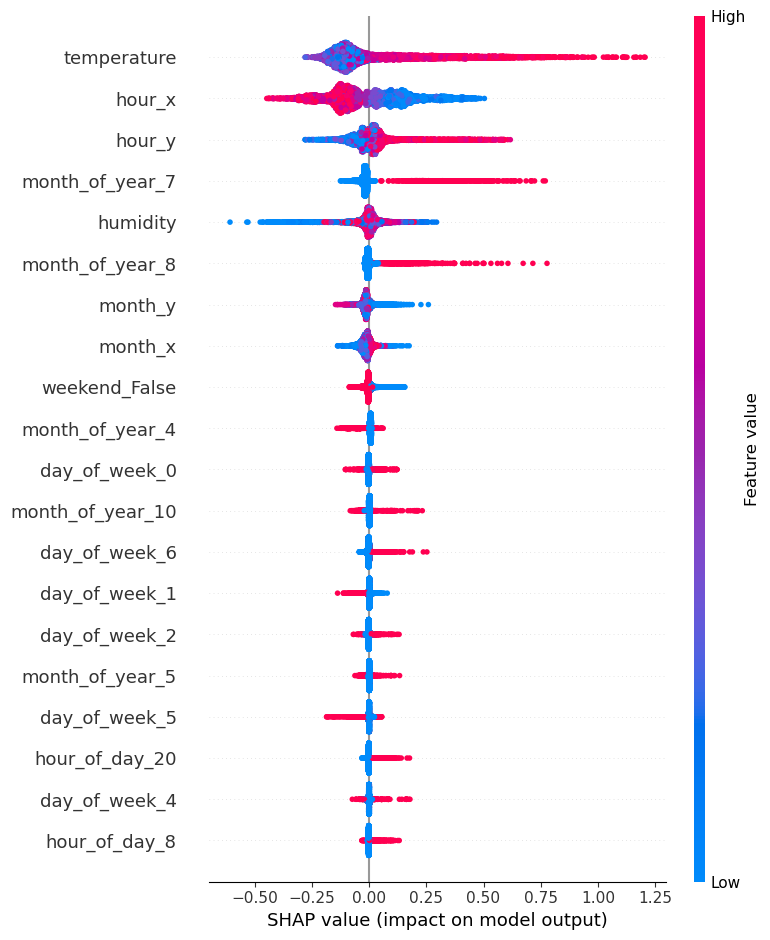

In [40]:
shap_values = explainer.shap_values(valid_x)
shap.summary_plot(shap_values, valid_x)

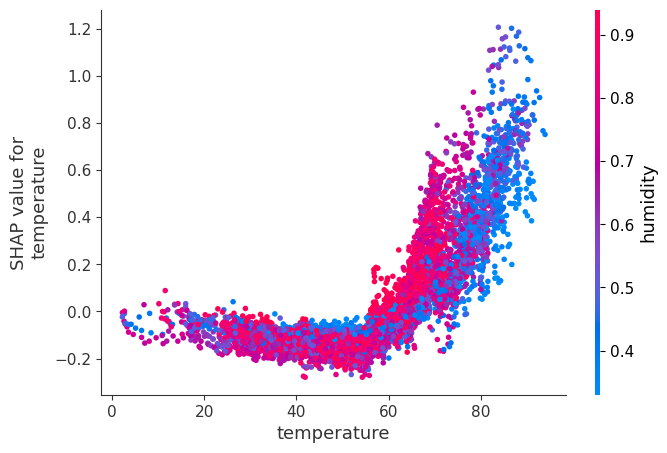

In [41]:
shap.dependence_plot("temperature", shap_values, valid_x, interaction_index="humidity")

In [42]:
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta

current_date = dt.strptime("2016-01", "%Y-%m")
past_date = current_date - relativedelta(months=4)
print(current_date, past_date)

2016-01-01 00:00:00 2015-09-01 00:00:00


In [50]:
bldg_df_1.loc[past_date:]

,power,hour_x,hour_y,month_x,month_y,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,weekend_False,weekend_True,temperature,humidity
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-09-01 00:00:00,1.317362,0.000000,1.000000,-1.000000e+00,-1.836970e-16,False,True,False,False,False,...,False,False,True,False,False,False,True,False,66.01,0.86
2015-09-01 01:00:00,1.114394,0.258819,0.965926,-1.000000e+00,-1.836970e-16,False,True,False,False,False,...,False,False,True,False,False,False,True,False,65.46,0.86
2015-09-01 02:00:00,0.502441,0.500000,0.866025,-1.000000e+00,-1.836970e-16,False,True,False,False,False,...,False,False,True,False,False,False,True,False,64.67,0.87
2015-09-01 03:00:00,1.479146,0.707107,0.707107,-1.000000e+00,-1.836970e-16,False,True,False,False,False,...,False,False,True,False,False,False,True,False,63.04,0.88
2015-09-01 04:00:00,0.522968,0.866025,0.500000,-1.000000e+00,-1.836970e-16,False,True,False,False,False,...,False,False,True,False,False,False,True,False,61.84,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 19:00:00,0.426538,-0.965926,0.258819,-2.449294e-16,1.000000e+00,False,False,False,False,True,...,False,False,False,False,False,True,True,False,35.94,0.75
2016-12-30 20:00:00,0.473570,-0.866025,0.500000,-2.449294e-16,1.000000e+00,False,False,False,False,True,...,False,False,False,False,False,True,True,False,38.08,0.71
2016-12-30 21:00:00,0.525701,-0.707107,0.707107,-2.449294e-16,1.000000e+00,False,False,False,False,True,...,False,False,False,False,False,True,True,False,36.65,0.81


In [64]:
without_weather = []
with_weather = []

current_date = dt.strptime("2016-01", "%Y-%m")

while current_date >= dt.strptime("2014-01", "%Y-%m"):
    with_weather.append(train_loop(bldg_df_1.loc[current_date:]))
    without_weather.append(train_loop(bldg_df_1.loc[current_date:].drop(columns=['temperature', 'humidity'])))
    
    current_date = current_date - relativedelta(months=2)

fit lightgbm to HomeB training start 2016-01-01 00:00:00 end 2016-09-30 17:00:00
fit lightgbm to HomeB training start 2016-01-01 00:00:00 end 2016-09-30 17:00:00
fit lightgbm to HomeB training start 2015-11-01 00:00:00 end 2016-09-15 11:00:00
fit lightgbm to HomeB training start 2015-11-01 00:00:00 end 2016-09-15 11:00:00
fit lightgbm to HomeB training start 2015-09-01 00:00:00 end 2016-08-31 05:00:00
fit lightgbm to HomeB training start 2015-09-01 00:00:00 end 2016-08-31 05:00:00
fit lightgbm to HomeB training start 2015-07-01 00:00:00 end 2016-08-15 17:00:00
fit lightgbm to HomeB training start 2015-07-01 00:00:00 end 2016-08-15 17:00:00
fit lightgbm to HomeB training start 2015-05-01 00:00:00 end 2016-07-31 11:00:00
fit lightgbm to HomeB training start 2015-05-01 00:00:00 end 2016-07-31 11:00:00
fit lightgbm to HomeB training start 2015-03-01 00:00:00 end 2016-07-16 05:00:00
fit lightgbm to HomeB training start 2015-03-01 00:00:00 end 2016-07-16 05:00:00
fit lightgbm to HomeB traini

In [63]:
without_weather.append(train_loop(bldg_df_1.loc[current_date:]))

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [65]:
without_weather

[0.7681607604026794,
 0.615637481212616,
 0.6470414400100708,
 0.6120579242706299,
 0.5988543629646301,
 0.564112663269043,
 0.5423502922058105,
 0.5894771814346313,
 0.6110779047012329,
 0.5932989716529846,
 0.6015434861183167,
 0.6069912314414978,
 0.6337053179740906]

In [66]:
with_weather

[0.6669431924819946,
 0.5974293351173401,
 0.6272202730178833,
 0.593071699142456,
 0.5778540372848511,
 0.5447267889976501,
 0.5258194804191589,
 0.5321760773658752,
 0.5643540620803833,
 0.5592696070671082,
 0.5931426286697388,
 0.5781018733978271,
 0.5848490595817566]

In [55]:
current_date >= dt.strptime("2016-02", "%Y-%m")

False

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Text(0, 0.5, 'NRMSE')

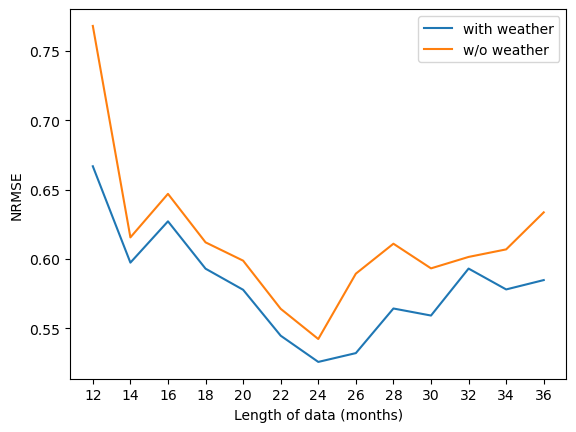

In [79]:
import numpy as np
size = np.arange(len(with_weather))
plt.plot(size, with_weather, label='with weather')
plt.plot(size, without_weather, label='w/o weather')
plt.legend()
plt.xticks(np.arange(len(with_weather)), np.arange(12, 12 + len(with_weather)*2, 2))
plt.xlabel('Length of data (months)')
plt.ylabel('NRMSE')

In [73]:
np.arange(12, 12 + len(with_weather)*2, 2)

array([12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])

In [33]:
df = bldg_df_1[['power', 'temperature']]

<Axes: >

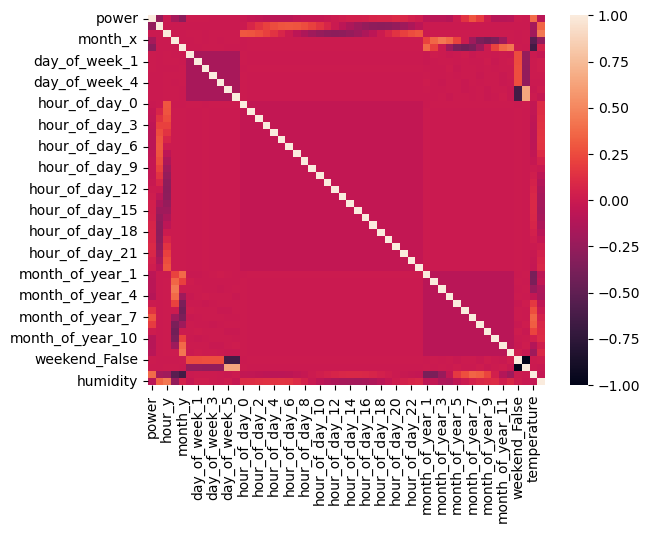

In [60]:
cormat = bldg_df_1.corr()

In [61]:
cormat.head(1)

,power,hour_x,hour_y,month_x,month_y,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,weekend_False,weekend_True,temperature,humidity
power,1.0,-0.258751,-0.004788,-0.177465,-0.296986,0.002006,0.001729,0.005177,-0.002802,-0.000533,...,0.282594,0.180516,0.00916,-0.093914,-0.099834,-0.088834,0.004322,-0.004322,0.380501,-0.079022


Text(0, 0.5, 'pearson')

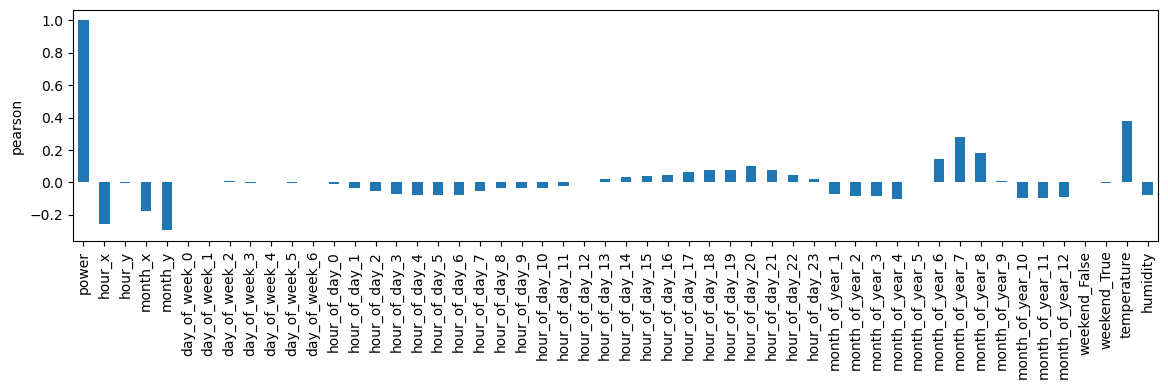

In [76]:
f,ax=plt.subplots(figsize=(14,3))
cormat.iloc[0].plot(kind='bar', ax=ax)
ax.set_ylabel('pearson')

In [34]:
overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")

Pandas computed Pearson r: 0.3805010306977187


In [35]:
r, p = stats.pearsonr(df['power'], df['temperature'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: 0.3805010306977173 and p-value: 0.0


In [58]:
df.corr()

,power,temperature
power,1.000000,0.380501
temperature,0.380501,1.000000


In [36]:
import numpy as np

[Text(0.5, 1.0, 'Overall Pearson r = 0.38')]

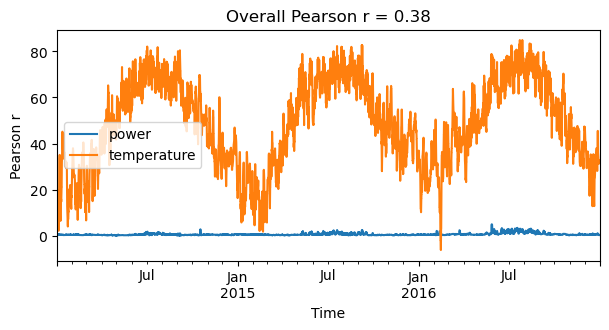

In [37]:
f,ax=plt.subplots(figsize=(7,3))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}")

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Pearson r')]

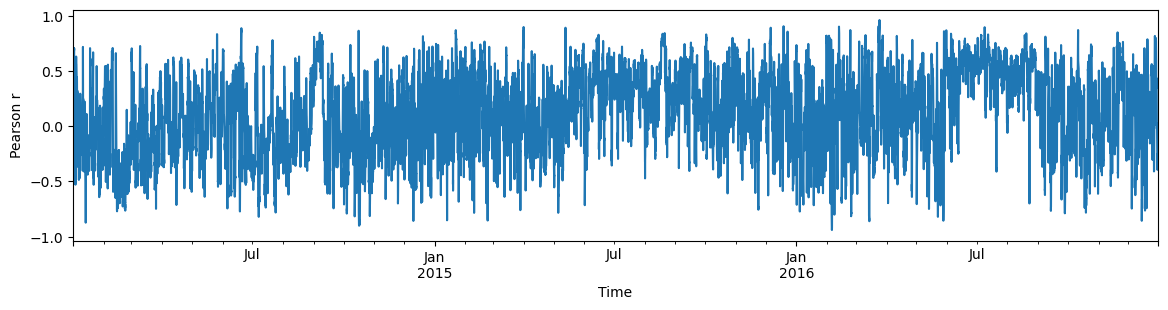

In [42]:
rolling_r =df['power'].rolling(window=24, center=True).corr(df['temperature'])
f,ax=plt.subplots(figsize=(14,3))
rolling_r.plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')


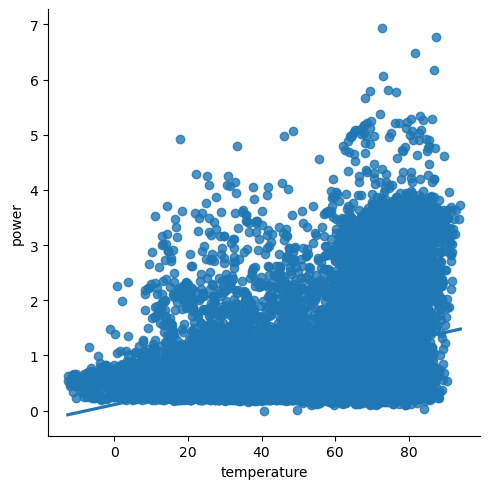

In [57]:
# sns.scatterplot(x=df['temperature'], y=df['power'])
ax = sns.lmplot(x="temperature", y="power", data=df)
ax.set_ylabels('power')
ax.set_xlabels('temperature')

In [45]:
df

,power,temperature
timestamp,,
2014-01-01 01:00:00,0.480605,19.22
2014-01-01 02:00:00,0.648437,18.10
2014-01-01 03:00:00,0.297454,17.47
2014-01-01 04:00:00,0.564292,15.63
2014-01-01 05:00:00,0.421209,15.33
...,...,...
2016-12-30 19:00:00,0.426538,35.94
2016-12-30 20:00:00,0.473570,38.08
2016-12-30 21:00:00,0.525701,36.65


In [50]:
df['temperature'].describe()

count    26279.000000
mean        49.279765
std         19.963686
min        -12.660000
25%         34.375000
50%         50.040000
75%         65.300000
max         93.960000
Name: temperature, dtype: float64